- Import Libraries

In [38]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

In [39]:
# open the csv file
df = pd.read_csv('/Users/arnav/Desktop/MachineLearning/Trumpformer/trump_tweets.csv')
df.head()

,id,text,is_retweet,is_deleted,device,favorites,retweets,datetime,is_flagged,date
0,9.845497e+16,Republicans and Democrats have both created ou...,False,False,TweetDeck,49,255,2011-08-02T18:07:48Z,False,2011-08-02
1,1.234653e+18,I was thrilled to be back in the Great city of...,False,False,Twitter for iPhone,73748,17404,2020-03-03T01:34:50Z,False,2020-03-03
2,1.218011e+18,RT @CBS_Herridge: READ: Letter to surveillance...,True,False,Twitter for iPhone,0,7396,2020-01-17T03:22:47Z,False,2020-01-17
3,1.304875e+18,The Unsolicited Mail In Ballot Scam is a major...,False,False,Twitter for iPhone,80527,23502,2020-09-12T20:10:58Z,False,2020-09-12
4,1.218160e+18,RT @MZHemingway: Very friendly telling of even...,True,False,Twitter for iPhone,0,9081,2020-01-17T13:13:59Z,False,2020-01-17


In [40]:
def extract_entities_from_tweet(tweet):
    entities = defaultdict(list)
    words = tweet.split()
    for word in words:
        if word.startswith('@'):
            entities['mentions'].append(word)
        elif word.startswith('#'):
            entities['hashtags'].append(word)
    return entities


df['entities'] = df['text'].apply(extract_entities_from_tweet)

# Show the entities and the tweets
df[['text', 'entities']].head()


,text,entities
0,Republicans and Democrats have both created ou...,{}
1,I was thrilled to be back in the Great city of...,{'hashtags': ['#KAG2020']}
2,RT @CBS_Herridge: READ: Letter to surveillance...,{'mentions': ['@CBS_Herridge:']}
3,The Unsolicited Mail In Ballot Scam is a major...,{}
4,RT @MZHemingway: Very friendly telling of even...,{'mentions': ['@MZHemingway:']}


- We will analyse the top 10 mentions and hashtags done by the author:

In [41]:
# The top 10 mentions not including @realDonaldTrump
mentions = [item for sublist in df['entities'].apply(lambda x: x['mentions']).tolist() for item in sublist]
mentions = [m for m in mentions if m != '@realDonaldTrump']
pd.Series(mentions).value_counts().head(10)


@realDonaldTrump:    1137
@WhiteHouse:          666
@FoxNews              664
@foxandfriends        554
@BarackObama          482
@ApprenticeNBC        300
@TeamTrump:           300
@CNN                  285
@GOPChairwoman:       213
@MittRomney           193
dtype: int64

In [42]:
# The top 10 hashtags
hashtags = [item for sublist in df['entities'].apply(lambda x: x['hashtags']).tolist() for item in sublist]
pd.Series(hashtags).value_counts().head(10)

#Trump2016                   434
#MAGA                        417
#MakeAmericaGreatAgain       281
#CelebApprentice             220
#Trump2016"""                170
#1                           110
#CelebrityApprentice          83
#MakeAmericaGreatAgain"""     71
#AmericaFirst                 65
#KAG2020                      63
dtype: int64

In [43]:
from pyvis.network import Network

# Create a PyVis network
nt = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")

In [44]:
# Create a NetworkX graph

G = nx.Graph()

# Add the top 10 mentions as nodes
top_10_mentions = [m[0] for m in pd.Series(mentions).value_counts().head(50).items()]
for mention in top_10_mentions:
    G.add_node(mention)

# Add the top 10 hashtags as nodes
top_10_hashtags = [h[0] for h in pd.Series(hashtags).value_counts().head(50).items()]

for hashtag in top_10_hashtags:
    G.add_node(hashtag)

# Add edges between mentions and hashtags
for index, row in df.iterrows():
    tweet_author = "DonaldTrump"  # Assuming all tweets are by Donald Trump
    for mention in row['entities']['mentions']:
        if mention in top_10_mentions:
            G.add_edge(tweet_author, mention)
    for hashtag in row['entities']['hashtags']:
        if hashtag in top_10_hashtags:
            G.add_edge(tweet_author, hashtag)

# Add the edges and nodes to the PyVis network
for node in G.nodes:
    nt.add_node(node)
for edge in G.edges:
    nt.add_edge(edge[0], edge[1])

# Save the network to a HTML file
nt.show_buttons(filter_=['physics'])
nt.show('trump_network.html')

trump_network.html


In [45]:
# Take Random Sample of 1000 tweets
df_sample = df.sample(1000)

# Remove the mentions and hashtags from the tweets
df_sample['text'] = df_sample['text'].str.replace('@\S+', '')
df_sample['text'] = df_sample['text'].str.replace('#\S+', '')

- Standard NLP Pre-processing

In [46]:
# Remove the URLs from the tweets
df_sample['text'] = df_sample['text'].str.replace('http\S+', '')

# Remove punctuation
df_sample['text'] = df_sample['text'].str.replace('[^\w\s]', '')

# Remove numbers
df_sample['text'] = df_sample['text'].str.replace('\d+', '')

# Convert to lowercase
df_sample['text'] = df_sample['text'].str.lower()

# Remove extra whitespace
df_sample['text'] = df_sample['text'].str.replace('\s+', ' ')

# Remove leading and trailing whitespace
df_sample['text'] = df_sample['text'].str.replace('^\s+|\s+$', '')

# Remove RT (retweet)
df_sample['text'] = df_sample['text'].str.replace('rt', '')

# Remove amp (html ampersand)
df_sample['text'] = df_sample['text'].str.replace('amp', '')

# Remove stop words
from nltk.corpus import stopwords

stop = stopwords.words('english')
df_sample['text'] = df_sample['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatize the tweets
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df_sample['text'] = df_sample['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


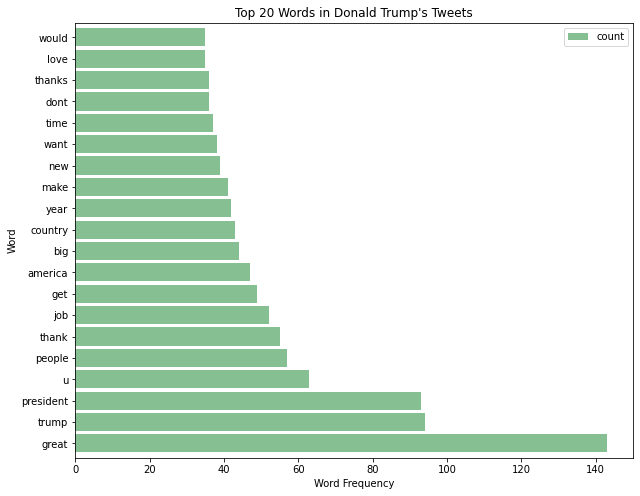

In [47]:
# Create a list of all the words in the tweets
words = [word for tweet in df_sample['text'] for word in tweet.split()]

# Create a word frequency dictionary
word_freq = defaultdict(int)

for word in words:
    word_freq[word] += 1

# Create a Pandas dataframe from the word frequency dictionary
df_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])

# Sort the dataframe by word frequency
df_freq.sort_values(by=['count'], ascending=False, inplace=True)

# Plot the top 20 words
df_freq.head(20).plot(kind='barh', figsize=(10, 8), color='#86bf91', zorder=2, width=0.85)

# Set the title and axis labels
plt.title("Top 20 Words in Donald Trump's Tweets")
plt.xlabel("Word Frequency")
plt.ylabel("Word")

# Show the plot
plt.show()

In [48]:
# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# Take tweets flagged as False
df_false = df[df['is_flagged'] == False]

# Remove the mentions and hashtags from the tweets
df_false['text'] = df_false['text'].str.replace('@\S+', '')
df_false['text'] = df_false['text'].str.replace('#\S+', '')

# Remove the URLs from the tweets
df_false['text'] = df_false['text'].str.replace('http\S+', '')

# Remove punctuation
df_false['text'] = df_false['text'].str.replace('[^\w\s]', '')

# Remove numbers
df_false['text'] = df_false['text'].str.replace('\d+', '')

# Convert to lowercase
df_false['text'] = df_false['text'].str.lower()

# Remove extra whitespace
df_false['text'] = df_false['text'].str.replace('\s+', ' ')

# Remove leading and trailing whitespace
df_false['text'] = df_false['text'].str.replace('^\s+|\s+$', '')

# Remove RT (retweet)
df_false['text'] = df_false['text'].str.replace('rt', '')

# Remove amp (html ampersand)
df_false['text'] = df_false['text'].str.replace('amp', '')

# Remove stop words
from nltk.corpus import stopwords

stop = stopwords.words('english')

df_false['text'] = df_false['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatize the tweets
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
df_false['text'] = df_false['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))



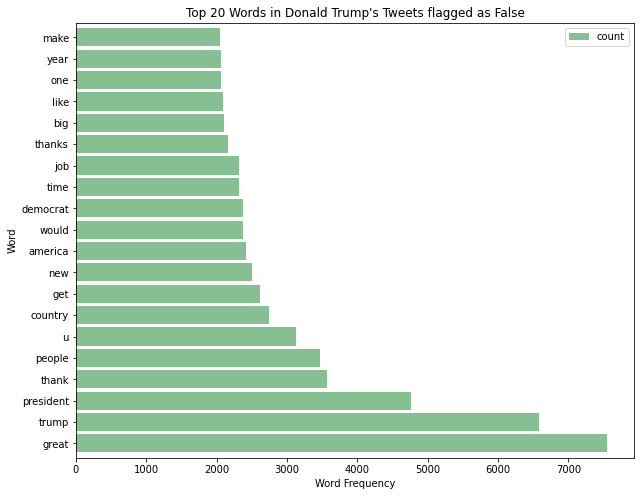

In [49]:
# Create a list of all the words in the tweets
words = [word for tweet in df_false['text'] for word in tweet.split()]

# Create a word frequency dictionary
word_freq = defaultdict(int)

for word in words:
    word_freq[word] += 1

# Create a Pandas dataframe from the word frequency dictionary
df_freq = pd.DataFrame.from_dict(word_freq, orient='index', columns=['count'])

# Sort the dataframe by word frequency
df_freq.sort_values(by=['count'], ascending=False, inplace=True)

# Plot the top 20 words
df_freq.head(20).plot(kind='barh', figsize=(10, 8), color='#86bf91', zorder=2, width=0.85)

# Set the title and axis labels
plt.title("Top 20 Words in Donald Trump's Tweets flagged as False")
plt.xlabel("Word Frequency")
plt.ylabel("Word")

# Show the plot
plt.show()